In [1]:
import os
import urllib
import json
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fpdf import FPDF

In [2]:
def import_json_to_dict(url) :
    response = urllib.request.urlopen(url)
    my_dict = json.loads(response.read())
    return my_dict

In [3]:
def mkdir_ifnotexist(path) :
    if not os.path.isdir(path) :
        os.mkdir(path)

In [4]:
def format_amount(indic, valeur):
    if "Montant" in indic:
        f_valeur = float(valeur)
        if f_valeur > 1000000:
            return str(round(f_valeur/1000000, 1)) + ' M€'
        elif f_valeur > 10000:
            return str(round(f_valeur/1000, 1)) + ' k€'
        else:
            return str(f_valeur)
    else:
        return int(valeur.split(".")[0])

In [5]:
mailles = ["national", "regional", "departemental"]

In [6]:
pp_dep = pd.read_csv("pp_dep.csv", sep=";", dtype={"reg":str})

In [7]:
list_mesure_indic = list(pp_dep.pivot_table(index=["short_mesure", "short_indic"], values="valeur").index)

In [8]:
short_mesures_to_keep =set([
'AAP et AMI Efficacité énergétique',
'Assurance prospection',
"Ma Prime Rénov'",
"Prime à l'embauche des jeunes",
"Prime à l'embauche pour les travailleurs handicapés",
"Apprentissage",
"Bonus électrique",
"Contrats Initiatives Emploi (CIE) Jeunes",
'Contrats de professionnalisation',
'France Num : aide à la numérisation des TPE,PME,ETI',
'Garantie jeunes',
"AAP industrie : Modernisation des filières auto et aéro",
"Parcours emploi compétences (PEC) Jeunes",
'Prime à la conversion des véhicules légers',
"AAP Industrie : Soutien aux projets industriels territoires",
"AAP Industrie : Sécurisation approvisionnements critiques",
"Renforcement subventions Business France",
'Rénovation des bâtiments Etats (marchés notifiés)',
"Service civique",
'Soutien recherche aéronautique civil'
])
#print(list_mesure_indic)
#print(list(x[0] for x in list_mesure_indic if not(x[0] in short_mesures_to_keep)))
list_mesure_indic = [x for x in list_mesure_indic if x[0] in short_mesures_to_keep]

In [9]:
pp_reg = pd.pivot_table(pp_dep, index=["mesure","short_mesure", "reg","region", "Date", "period_date", "short_indic"], values="valeur", aggfunc=np.sum)
pp_reg.rename(columns={"reg":"libelle"}, inplace=True)
pp_reg.reset_index(inplace=True)

In [10]:
pp_nat = pd.pivot_table(pp_reg, index=["mesure", "short_mesure", "Date","period_date", "short_indic"], values="valeur", aggfunc=np.sum)
pp_nat.reset_index(inplace=True)

In [11]:
dict_mesure_indic = {}
for x in list_mesure_indic:
    if x[0] in dict_mesure_indic:
        dict_mesure_indic[x[0]].append(x[1])
    else:
        dict_mesure_indic[x[0]] = [x[1]]

In [12]:
dict_mesure_indic['AAP Industrie : Soutien aux projets industriels territoires'] = ['Nombre de TPE,PME,ETI bénéficiaires']
dict_mesure_indic['AAP Industrie : Sécurisation approvisionnements critiques'] = ['Nombre de TPE,PME,ETI bénéficiaires']
dict_mesure_indic['AAP et AMI Efficacité énergétique'] = ["Nombre d'entreprises ayant reçu l'aide"]
dict_mesure_indic['AAP industrie : Modernisation des filières auto et aéro'] = ['Nombre de PME']

In [13]:
# On ne veut pas afficher les lignes de Prime Rénov nulles
pp_dep = pp_dep.loc[(pp_dep.short_mesure != "Ma Prime Rénov'") | (pp_dep.valeur != 0) ]

In [14]:
pp_dep.valeur = pp_dep.valeur.astype(str)
pp_dep.valeur = pp_dep.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [15]:
pp_reg.valeur = pp_reg.valeur.astype(str)
pp_reg.valeur = pp_reg.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [16]:
pp_nat.valeur = pp_nat.valeur.astype(str)
pp_nat.valeur = pp_nat.apply(lambda x: format_amount(x["short_indic"], x["valeur"]), axis=1)

In [17]:
taxo_dep_url = 'https://raw.githubusercontent.com/etalab/dashboard-aides-entreprises/master/backend/json/taxonomies/departements-minify.json'
taxo_reg_url = 'https://raw.githubusercontent.com/etalab/dashboard-aides-entreprises/master/backend/json/taxonomies/regions-minify.json'

In [18]:
taxo_dep_df = pd.DataFrame(import_json_to_dict(taxo_dep_url))
dep_list = list(taxo_dep_df['dep'])
print('{} departements.'.format(len(dep_list)))

taxo_reg_df = pd.DataFrame(import_json_to_dict(taxo_reg_url))
reg_list = list(taxo_reg_df['reg'])
print('{} regions.'.format(len(reg_list)))

101 departements.
18 regions.


In [19]:
#Building the folders structures
pp_img_dir_path = './pp_img'
img_dir_path = './img/'
reports_dir_path = './reports/'

mkdir_ifnotexist(pp_img_dir_path)
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'national'))
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'national', 'France'))

#Regions subfolders
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'regional'))
for reg in reg_list :
    mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'regional', reg))
    
#Departements subfolders
mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'departemental'))
for dep in dep_list :
    mkdir_ifnotexist(os.path.join(pp_img_dir_path, 'departemental', dep))

mkdir_ifnotexist(reports_dir_path)

In [150]:
def make_pp_chart(maille, mesure, short_indics) :
    if maille == "departemental":
        df = pp_dep.loc[(pp_dep.short_mesure == mesure)].sort_values(by="period_date", ascending=True).copy()
        deps = pp_dep.dep.unique()
        
        default = df.groupby(["Date", "period_date"]).sum().sort_values("period_date", ascending=True).reset_index()
        default[short_indics] = 0
        default = default[["Date"] + short_indics]

        for dep in deps:
            print(f"Plotting {mesure}-{short_indics} : departement {dep}")
            df_dep = df.loc[df.dep == dep]
            if df_dep.shape[0] == 0:
                ax = pp_plot(default)
            else:
                df_plot = pd.pivot_table(df_dep, index=['period_date', 'Date'], columns=['short_indic'], values='valeur', aggfunc='first')
                df_plot = df_plot.reset_index().drop('period_date', axis=1)
                df_plot = df_plot.rename_axis(None, axis=1)
                ax = pp_plot(df_plot)
            save_pp_plot(maille, dep, mesure, ax)  # short_indic est inutile dans le nom
            
    elif maille == "regional":
        df = pp_reg.loc[(pp_reg.short_mesure == mesure)].sort_values(by="period_date", ascending=True).copy()
        regs = df.reg.unique()
        
        default = df.groupby(["Date", "period_date"]).sum().sort_values("period_date", ascending=True).reset_index()
        default[short_indics] = 0
        default = default[["Date"] + short_indics]

        for reg in regs:
            print(f"Plotting region {mesure}-{short_indics} : {reg}")
            df_reg = df.loc[df.reg == reg]
            if df_reg.shape[0] == 0:
                ax = pp_plot(default)
            else:
                df_plot = pd.pivot_table(df_reg, index=['period_date', 'Date'], columns=['short_indic'], values='valeur', aggfunc='first')
                df_plot = df_plot.reset_index().drop('period_date', axis=1)
                df_plot = df_plot.rename_axis(None, axis=1)
                ax = pp_plot(df_plot)
            save_pp_plot(maille, reg, mesure, ax)
            
    elif maille == "national":
        print(f"Plotting country {mesure}-{short_indics}")
        df_nat = pp_nat.loc[(pp_nat.short_mesure == mesure)].sort_values(by="period_date", ascending=True).copy()
        df_plot = pd.pivot_table(df_nat, index=['period_date', 'Date'], columns=['short_indic'], values='valeur', aggfunc='first')
        df_plot = df_plot.reset_index().drop('period_date', axis=1)
        df_plot = df_plot.rename_axis(None, axis=1)
        ax = pp_plot(df_plot)#, mesure, short_indic, "France")
        save_pp_plot(maille, "France", mesure, ax)

In [142]:
def pp_plot(data, col_width=12, row_height=1.2, font_size=20,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax

In [152]:
def save_pp_plot(maille, geo, mesure, ax):
    print(maille, geo, mesure)
    path = os.path.join("pp_img", maille, geo)
    ax.figure.savefig(os.path.join(path, "{}.png".format(mesure)))
    plt.close()

In [156]:
def make_all_charts():
    for short_mesure in dict_mesure_indic:
        short_indics = dict_mesure_indic[short_mesure]
        for maille in mailles :
            make_pp_chart(maille, short_mesure, short_indics)

Plotting country AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires']
national France AAP Industrie : Soutien aux projets industriels territoires
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 28
regional 28 AAP Industrie : Soutien aux projets industriels territoires
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 32
regional 32 AAP Industrie : Soutien aux projets industriels territoires
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 94
regional 94 AAP Industrie : Soutien aux projets industriels territoires
Plotting region AAP Industrie : Soutien aux projets industriels territoires-['Nombre de TPE,PME,ETI bénéficiaires'] : 27
regional 27 AAP Industrie : Soutien aux projets industriels territoires
Plotting region AAP Industrie : Sou

KeyboardInterrupt: 

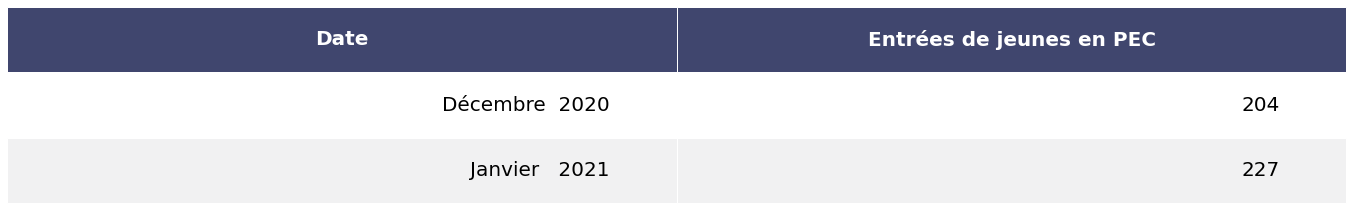

In [157]:
#%%time
make_all_charts()

In [25]:
col_width=6.0
row_height=0.625
font_size=14

In [26]:
global title_header
title_header = ''
global subtitle_header
subtitle_header = ''

In [27]:
class PDF(FPDF):
    def header(self):
        if (self.page_no() != 1 ):
            # Logo
            self.image(os.path.join(img_dir_path, 'LogoRF.png'), 10, 8, 33)
            self.image(os.path.join(img_dir_path, 'logo_Francerelance_1321294.54.png'), pdf.w-45, 7, 45)
            # Arial bold 15
            self.cell(40)
            self.add_font('Arial', 'B', 16, uni=True)
            self.set_font('Arial', 'B', 16)
            self.multi_cell(110, 10, title_header, 0, 1, 'A')

            # Move to the right
            # Title
            self.set_font('Arial', 'I', 9)
            self.cell(50)
            self.cell(50)
            #self.cell(50, 10, subtitle_header, 0, 1, 'A')#+' - aides-entreprises.data.gouv.fr', 0, 1, 'A', link='https://aides-entreprises.data.gouv.fr/')
            # Line break  
            pdf.line(40, 38, 170, 38)
            self.ln(7)
        
    # Page footer
    def footer(self):
        if (self.page_no() != 1 ):
            # Position at 1.5 cm from bottom
            self.set_y(-15)
            # Arial italic 8
            self.set_font('Arial', 'I', 8)
            # Page number
            
            #self.cell(0, 10, 'Direction Interministérielle du Numérique (DINUM) - Page ' + str(self.page_no()) + '/{nb}', 0, 0, 'C')         

In [28]:
def add_propilot_page_report(pdf, dep, short_mesure, phrase_nombre, source_dict):
    
    pdf.set_fill_color(83,101,125);

    pdf.set_y(47.00125)
    
    
    # Print KPI
    short_indic = dict_mesure_indic[short_mesure][0]
    kpi_dep = (pp_dep.loc[(pp_dep.dep == dep) 
                          & (pp_dep.short_mesure == short_mesure) 
                          & (pp_dep.short_indic == short_indic)]
                .sort_values(by="period_date", ascending=False))
    if kpi_dep.shape[0] != 0:
        date= kpi_dep.iloc[0].Date
        valeur = kpi_dep.iloc[0].valeur
    else:
        date = pp_dep.Date.max()
        valeur = 0
    
    pdf.add_font('Arial', '', 'arial.ttf', uni=True)
    pdf.set_font('Arial', '', 12)
    pdf.cell(12, 10, f"À {date}, {short_indic} : {valeur} (données cumulées)")
    pdf.ln(10)
 
    pdf.set_text_color(0,0,0)

    # Niveau National
    pdf.set_font('Arial', 'BI', 14)
    pdf.cell(65, 10, "Niveau National", ln=1)
    
    pdf.set_font('Arial', '', 14)

    hbar_w = 120
    pdf.image(os.path.join(pp_img_dir_path, 'national','France', f"{short_mesure}-{short_indic}.png"), 
              x=0, y=74, w=hbar_w)

    pdf.ln(12)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(27)

    reg = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['reg']
    libelle_reg = taxo_reg_df[taxo_reg_df['reg'] == reg].iloc[0]['libelle']
    libelle_dep = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
    
    
    # Niveau Régional
    pdf.set_font('Arial', 'BI', 14)
    pdf.cell(65, 10, "Niveau Régional : "+libelle_reg, ln=1)

    pdf.set_font('Arial', '', 14)

    path_reg = os.path.join(pp_img_dir_path, 'regional',reg, f"{short_mesure}-{short_indic}.png")
    if os.path.exists(path_reg):    
        pdf.image(path_reg, x=0, y=133, w=hbar_w)
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(15)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(10)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(25)

    # Niveau Départemental
    pdf.set_font('Arial', 'BI', 14)
    pdf.cell(65, 15, "Niveau Départemental : "+libelle_dep, ln=1) 

    pdf.set_font('Arial', '', 14)
    path_dep = os.path.join(pp_img_dir_path, 'departemental', dep, f"{short_mesure}-{short_indic}.png")
    if os.path.exists(path_dep):
        pdf.image(path_dep, x=0, y=210, w=hbar_w)
        
    pdf.ln(8)
    pdf.cell((pdf.w/3)*1.55)
    pdf.ln(15)
    pdf.cell((pdf.w/3)*1.55)
    
    return pdf

In [30]:
#%%time

mkdir_ifnotexist(os.path.join(reports_dir_path))

counter = 0
for dep in taxo_dep_df.dep.unique():
    counter += 1
    
    pdf = PDF()
    pdf.alias_nb_pages()
    pdf.add_page()

    #Logos
    pdf.image(os.path.join(img_dir_path, 'LogoRF.png'), 10, 8, 33)
    pdf.image(os.path.join(img_dir_path, 'logo_Francerelance_1321294.54.png'), pdf.w-45, 7, 45)
    
    # Arial bold 15
    pdf.set_font('Arial', 'B', 28)
    # Move to the right
    pdf.cell(50)
    pdf.ln(70)
    
    # Title
    pdf.cell(10)
    pdf.cell(50, 10, 'SUIVI TERRITORIAL', 0, 1, 'A')
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50, 10, 'DU PLAN DE RELANCE', 0, 1, 'A')
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50)

    pdf.set_font('Arial', 'I', 20)
    pdf.ln(10)
    pdf.cell(10)
    pdf.cell(50, 10, 'Données pour le département : '+taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle'], 0, 1, 'A')
    pdf.ln(110)

    pdf.set_font('Arial', 'I', 8)

    pdf.cell(10)
       
    # TEST PROPILOT
    for short_mesure in short_mesures_to_keep:
        source_dict= {'name':'Les données utilisées proviennent de ProPilot', 
                      'url':'https://dares.travail-emploi.gouv.fr/dares-etudes-et-statistiques/tableaux-de-bord/le-marche-du-travail-pendant-le-covid-19/tableaux-de-bord-hebdomadaires'}

        title_header = short_mesure
        
        pdf.add_page()
        pdf = add_propilot_page_report(pdf, dep, short_mesure,' : ', source_dict) 
    departement = taxo_dep_df[taxo_dep_df['dep'] == dep].iloc[0]['libelle']
    pdf.output(os.path.join(reports_dir_path, 'Suivi_territorial_plan_relance_'+ departement+'.pdf'), 'F')
    
    print(str(datetime.datetime.today()) + ' - ' + dep + ' done.')

2021-03-16 14:23:44.661106 - 01 done.
2021-03-16 14:24:02.358003 - 02 done.
2021-03-16 14:24:19.926492 - 03 done.
2021-03-16 14:24:37.477575 - 04 done.
2021-03-16 14:24:55.247783 - 05 done.
2021-03-16 14:25:12.753728 - 06 done.
2021-03-16 14:25:30.541740 - 07 done.
2021-03-16 14:25:48.413669 - 08 done.
2021-03-16 14:26:06.284398 - 09 done.
2021-03-16 14:26:24.057820 - 10 done.
2021-03-16 14:26:41.694200 - 11 done.
2021-03-16 14:26:59.285942 - 12 done.
2021-03-16 14:27:16.938174 - 13 done.
2021-03-16 14:27:34.921621 - 14 done.
2021-03-16 14:27:53.644768 - 15 done.
2021-03-16 14:28:11.912594 - 16 done.
2021-03-16 14:28:29.341026 - 17 done.
2021-03-16 14:28:46.747231 - 18 done.
2021-03-16 14:29:04.175134 - 19 done.
2021-03-16 14:29:21.520427 - 21 done.
2021-03-16 14:29:38.750763 - 22 done.
2021-03-16 14:29:56.083689 - 23 done.
2021-03-16 14:30:13.007412 - 24 done.
2021-03-16 14:30:30.847538 - 25 done.
2021-03-16 14:30:48.069295 - 26 done.
2021-03-16 14:31:05.506551 - 27 done.
2021-03-16 1